### ノック31：データを読み込んで確認しよう

In [1]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        1
dtype: int64

In [2]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### ノック32：クラスタリングで顧客をグループ化しよう

In [3]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 3 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


### ノック33：クラスタリング結果を分析しよう

In [7]:
customer_clustering.columns = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']
customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [8]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


### ノック34：クラスタリング結果を可視化してみよう

In [9]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

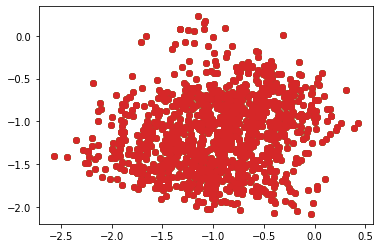

In [11]:
for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == 1]
    plt.scatter(tmp[0], tmp[1])

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [12]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [13]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


### ノック36：翌月の利用回数予測を行うための準備をしよう

In [14]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime("%Y%m")
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id':'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [15]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()

for i, year_month in enumerate(year_months[6:], 6):
    predict_data_month = uselog_months.loc[uselog_months["年月"] == year_month] 
    predict_data_month.rename(columns={"count":"count_pred"}, inplace=True)

    for j in range(1, 7):
        past_data = uselog_months.loc[uselog_months["年月"] == year_months[i-j]]
        del past_data["年月"]
        past_data.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        predict_data_month = pd.merge(predict_data_month, past_data, on="customer_id", how="left")

    predict_data = pd.concat([predict_data, predict_data_month], ignore_index=True)

predict_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [16]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [17]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [20]:
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format="%Y%m")
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])
from dateutil.relativedelta import relativedelta
predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years * 12 + delta.months
predict_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [22]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [23]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5597678045922347
0.34119980101423575


### ノック39：モデルに寄与している変数を確認しよう

In [25]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.coef_})
coef

,feature_names,coefficient
0,count_0,0.619332
1,count_1,-0.018015
2,count_2,0.181496
3,count_3,0.034434
4,count_4,0.116716
5,count_5,0.183609
6,period,0.326224


### ノック40：来月の利用回数を予測しよう

In [26]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [27]:
model.predict(x_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([3.78463065, 2.26605594])

In [28]:
uselog_months.to_csv('use_log_months.csv', index=False)